# import

In [3]:
#las de siempre
import pandas as pd
import numpy as np
import json

#para importar cosas
import fastparquet
from tqdm import tqdm
import jsonlines

#para graficar cosas
import matplotlib.pyplot as plt
import seaborn as sns

#para handlear fechas
from datetime import timedelta

import multiprocessing as mp
from itertools import chain, islice

## importar df

In [2]:
df_train = pd.read_parquet(r"C:\Users\fvogel_pickit\Downloads\DATA-MELI\train_data.parquet")
df_test = pd.read_csv( r"C:\Users\fvogel_pickit\Downloads\DATA-MELI\test_data.csv")

In [3]:
def read_jl( filename ):
    rv = []
    for obj in tqdm( jsonlines.open( filename ) ):
        rv.append( obj )
    return rv

metadata = read_jl( r"C:\Users\fvogel_pickit\Downloads\DATA-MELI\items_static_metadata_full.jl" )
df_meta = pd.DataFrame( metadata )

660916it [00:10, 65641.29it/s]


In [4]:
df_train = df_train.merge(df_meta, on='sku', how='left')
df_test = df_test.merge(df_meta, on='sku', how='left')

# explore

In [5]:
df_train.head(5)

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,item_domain_id,item_id,item_title,site_id,product_id,product_family_id
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510


In [ ]:
def plot_ts( data, time , series, level = None):
    
    plt.figure( figsize=(15,4))
    plt.title(f'{series} time series grouped by {level}' )
    sns.lineplot( data=data,
                x = time,
                y = series,
                hue = level)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
grupete = df_train.groupby(['site_id','date']).sold_quantity.sum().reset_index()

In [ ]:
plot_ts(grupete, 'date', 'sold_quantity', 'site_id' )

In [ ]:
df_train['week'] = pd.to_datetime( df_train.date).dt.isocalendar().week

In [ ]:
grupete_w = df_train.groupby(['site_id','week']).sold_quantity.sum().reset_index()
plot_ts(grupete_w, 'week', 'sold_quantity', 'site_id' )

# build validation set

In [6]:
df_train.date.min(), df_train.date.max()

('2021-02-01', '2021-03-31')

In [7]:
split_date = (pd.to_datetime(df_train.date).max()-timedelta(days=30)).date()
print(split_date)

#separete the last 30 days for validation
data_val = df_train.loc[(df_train.date > str(split_date))]

#use the rest as training
data_train = df_train.loc[(df_train.date <= str(split_date))]

2021-03-01


In [8]:
#disclaimer: this is not the code that was used to generate the test_set.
# It was made from scratch

def create_validation_set(dataset):
    np.random.seed(42)
    print('Sorting records...')
    temp_pd = dataset.loc[:, ['sku','date','sold_quantity']].sort_values(['sku','date'])

    print('Grouping quantity...')
    temp_dict = temp_pd.groupby('sku').agg({'sold_quantity':lambda x: [i for i in x]})['sold_quantity'].to_dict()

    result = []
    for idx, list_quantity in tqdm(temp_dict.items(), desc='Making targets...'):
        cumsum = np.array(list_quantity).cumsum()
        stock_target = 0
        if cumsum[-1] > 0 and len(cumsum)==30:
            
            #choose a random target different from 0
            while stock_target == 0:
                stock_target = np.random.choice(cumsum)
                
            #get the first day with this amounnt of sales
            day_to_stockout = np.argwhere(cumsum==stock_target).min() + 1
            
            #add to a list
            result.append({'sku':idx, 'target_stock':stock_target, 'inventory_days':day_to_stockout})
    return result

#generate target for the 30 days of validation
val_dataset = create_validation_set(data_val)

Sorting records...
Grouping quantity...


Making targets...: 100%|████████████████████████████████████████████████████| 660916/660916 [00:49<00:00, 13290.13it/s]


In [9]:
y_true_val = [x['inventory_days'] for x in val_dataset]

In [10]:
val_dataset

[{'sku': 0, 'target_stock': 1, 'inventory_days': 16},
 {'sku': 1, 'target_stock': 14, 'inventory_days': 27},
 {'sku': 3, 'target_stock': 1, 'inventory_days': 30},
 {'sku': 4, 'target_stock': 2, 'inventory_days': 5},
 {'sku': 5, 'target_stock': 11, 'inventory_days': 28},
 {'sku': 6, 'target_stock': 6, 'inventory_days': 21},
 {'sku': 7, 'target_stock': 28, 'inventory_days': 11},
 {'sku': 9, 'target_stock': 13, 'inventory_days': 23},
 {'sku': 10, 'target_stock': 3, 'inventory_days': 21},
 {'sku': 11, 'target_stock': 10, 'inventory_days': 7},
 {'sku': 13, 'target_stock': 3, 'inventory_days': 12},
 {'sku': 14, 'target_stock': 9, 'inventory_days': 25},
 {'sku': 15, 'target_stock': 8, 'inventory_days': 16},
 {'sku': 16, 'target_stock': 3, 'inventory_days': 26},
 {'sku': 17, 'target_stock': 9, 'inventory_days': 24},
 {'sku': 18, 'target_stock': 7, 'inventory_days': 10},
 {'sku': 19, 'target_stock': 8, 'inventory_days': 28},
 {'sku': 20, 'target_stock': 24, 'inventory_days': 16},
 {'sku': 23, '

# Model

## uniforme

In [ ]:
df_test.shape

In [5]:
[(np.ones(30)/30).round(5).tolist()] * len(val_dataset)

NameError: name 'val_dataset' is not defined

In [11]:
y_pred_uniform = [(np.ones(30)/30).round(5).tolist()] * len(val_dataset)
pd.DataFrame(y_pred_uniform, columns=range(1,30+1)).head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,...,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333
1,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,...,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333
2,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,...,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333
3,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,...,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333
4,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,...,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333,0.03333


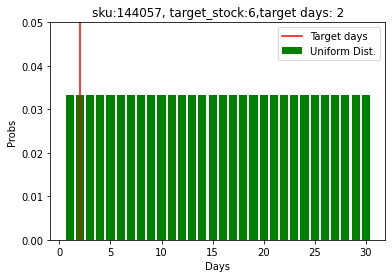

In [12]:
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
plt.ylim([0,0.05])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31), np.ones(30)/30, color='green')

plt.xlabel('Days')
plt.ylabel('Probs')
plt.legend(['Target days', 'Uniform Dist.'])
plt.show()

In [13]:
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

In [14]:
uniform_score = scoring_function(y_true_val, y_pred_uniform)
print('Uniform model got a validation RPS of: ',uniform_score)

<ipython-input-13-54e0998fbfdd>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true_one_hot = np.zeros_like(y_pred, dtype=np.float)


Uniform model got a validation RPS of:  4.865474069111363


## Distribucion normal

In [5]:
def generate_batch_predictions(model, x_test, batch_size=10000, processors=-1):
    """Function usefull for paralellize inference"""
    pool = mp.Pool(processors)
    batches = batchify(x_test,batch_size)
    results = pool.imap(model.predict_batch,batches)
    pool.close()
    output = []
    for r in tqdm(results, total=int(len(x_test)/batch_size), desc='generating preds...'):
        output.extend(r)
    preds_dict = {}
    for sku,probs in tqdm(output):
        preds_dict[sku] = probs
    y_pred = []
    for x in tqdm(x_test):
        pred = preds_dict[x['sku']]
        y_pred.append(pred)
    return y_pred


def batchify(iterable, batch_size):
    """Convert an iterable in a batch-iterable"""
    iterator = iter(iterable)
    for first in iterator:
        yield list(chain([first], islice(iterator, batch_size - 1)))

In [6]:
from scipy.stats import norm
step=1
model_ = norm(15, 10)

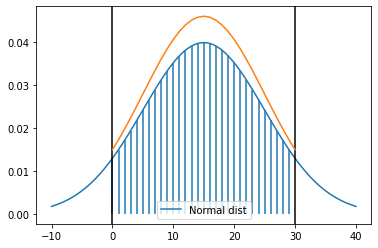

In [10]:
if step >= 1:
    x_axis = np.arange(-10, 40, 0.001)
    plt.plot(x_axis, model_.pdf(x_axis))
    plt.legend(['Normal dist'])

if step >= 2:    
    plt.axvline(0, color='black')
    plt.axvline(30, color='black')
    
if step >= 3:
    for i in range(30):
        plt.vlines(i,ymin=0,ymax=model_.pdf(i))

if step >= 4:
    scale = model_.cdf(30) - model_.cdf(0)
    x_axis = np.arange(0, 31, 1)
    plt.plot(x_axis, model_.pdf(x_axis)/scale)
    step = 0
step += 1
plt.show()

In [11]:
from scipy.stats import norm
from tqdm import tqdm

class LinearModel():
    """
    Linear model based on sold_quantity
    """
    def __init__(self, 
                 last_n_days=None, 
                 normalize=True):
        
        self.normalize = normalize
        self.last_n_days = last_n_days
        self.border_cases = 0
        self.normal_cases = 0
        
    def fit(self, data):
        """ Store mean and std-dev for each SKU """
        
        if self.last_n_days != None:
            min_training_date = str((pd.to_datetime(data.date.max())-timedelta(days=self.last_n_days)).date())
        else:
            min_training_date = str(data.date.min().date())
            
        self.parameters = (data[data.date >= min_training_date]
                           .groupby('sku')
                           .agg({'sold_quantity':['mean', 'std']})
                           .sold_quantity
                           .to_dict())

        self.general_mean = data.sold_quantity.mean()
        self.general_std = data.sold_quantity.std()
        return self 
    
    def calc_probs(self, norm_dist):
        #cut probs in days
        probs = []
        for i in range(1, 31):
            probs.append(norm_dist.cdf(i+1) - norm_dist.cdf(i))
        
        #if prob is zero, replace with uniform
        if np.sum(probs) == 0:
            return np.ones(30) / 30

        if self.normalize:
            probs = probs / np.sum(probs)
        return probs
    
    def predict(self, idx, stock):
        """ calculate mean and variance to stockout for a given SKU """
        #retrieve the mean and variance for the SKU
        if self.parameters['mean'].get(idx, 0.) != 0.:
            mean = self.parameters['mean'][idx]
            std = self.parameters['std'][idx]        
            self.normal_cases += 1
        else:
            #to catch border cases where there is no data in train or has all 0s.
            mean = self.general_mean
            std = self.general_std    
            self.border_cases += 1
            
        if std == 0. or np.isnan(std):
            std = self.general_std
        
        #convert quantities into days
        days_to_stockout = stock / mean
        std_days = (std / mean) * days_to_stockout
        return days_to_stockout, std_days
    
    def predict_proba(self, idx, stock):
        """ Calculates the 30 days probs given a SKU and a target_stock """
        days_to_stockout, std_days = self.predict(idx, stock)
        norm_dist = norm(days_to_stockout, std_days)
        return self.calc_probs(norm_dist)
    
    def predict_batch(self, X, proba=True):
        """ 
        Predict probs for many SKUs 
        Input:
            X: List of Dicts with keys sku and target_stock
        """
        result = []
        for x in X:
            idx = x['sku']
            stock = x['target_stock']
            if proba:
                result.append((idx, self.predict_proba(idx, stock)))
            else:
                result.append((idx, self.predict(idx, stock)))
        return result

In [13]:
data_train = df_train

In [14]:
%%time
model = LinearModel(last_n_days=14, normalize=True)

#train the model with train data
model.fit(data_train)

Wall time: 1min 47s


In [15]:
y_pred_normal = generate_batch_predictions(model, val_dataset, batch_size=10000, processors=20)

NameError: name 'val_dataset' is not defined

In [ ]:
print("opa")

# armar el modelo para submitear

In [16]:
def array2text(y_pred):
    """convert a list of number in a list of texts with 4 decimal positions """
    result = []
    for xs in tqdm(y_pred):
        line = []
        for x in xs:
            line.append('{:.4f}'.format(x))
        result.append(line)
    return result

def make_submission_file(y_pred, file_name='submission_file', compress=True, single_row=True):
    """Convert a list of text into a submition file"""
    result = array2text(y_pred)
    if compress:
        if single_row:
            file_name = f'{file_name}.csv.gz'
            with gzip.open(file_name, "wt") as f:
                writer = csv.writer(f)
                for row in tqdm(result, desc='making file...'):
                    writer.writerow(row)
        else:
            file_name = f'{file_name}.csv.gz'
            with gzip.open(file_name, "wt") as f:
                writer = csv.writer(f)
                writer.writerows(result)
    else:
        if single_row:
            file_name = f'{file_name}.csv'            
            with open(file_name, "w") as f:
                writer = csv.writer(f)
                for row in tqdm(result, desc='making file...'):
                    writer.writerow(row)
        else:
            file_name = f'{file_name}.csv'
            with open(file_name, "w") as f:
                writer = csv.writer(f)
                writer.writerows(result)
    return file_name

def read_submission_file(file_name, compress=False):
    if compress:
        with gzip.open(file_name, 'rt') as f:
            submission = f.read()
    else:
        with open(file_name, 'r') as f:
            submission = f.read()

In [19]:
data_test = df_test

In [ ]:
x_test = data_test.reset_index()[['index','sku','target_stock']].to_dict(orient='records')

y_pred = generate_batch_predictions(model, x_test, batch_size=10000, processors=20)

generating preds...:   0%|                                                                      | 0/55 [00:00<?, ?it/s]

In [17]:
file_name = make_submission_file(y_pred, 'submittion_file_linear_model', compress=True, single_row=True)
print(f'Submission file created at: {file_name}')

NameError: name 'y_pred' is not defined